
## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255.

In this example, each image will be converted to float32, normalized to [0, 1] and flattened to a 1-D array of 784 features (28*28).

In [1]:

from __future__ import absolute_import, division, print_function

import tensorflow as tf
import numpy as np

In [2]:
# MNIST dataset parameters.
num_classes = 10 # 0 to 9 digits
num_features = 784 # 28*28

# Training parameters.
learning_rate = 0.01
training_steps = 1000
batch_size = 256
display_step = 50

In [3]:

# Prepare MNIST data.
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Convert to float32.
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
# Flatten images to 1-D vector of 784 features (28*28).
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
# Normalize images value from [0, 255] to [0, 1].
x_train, x_test = x_train / 255., x_test / 255.

11493376/11490434 [==============================] - 18s 2us/step


In [4]:
# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

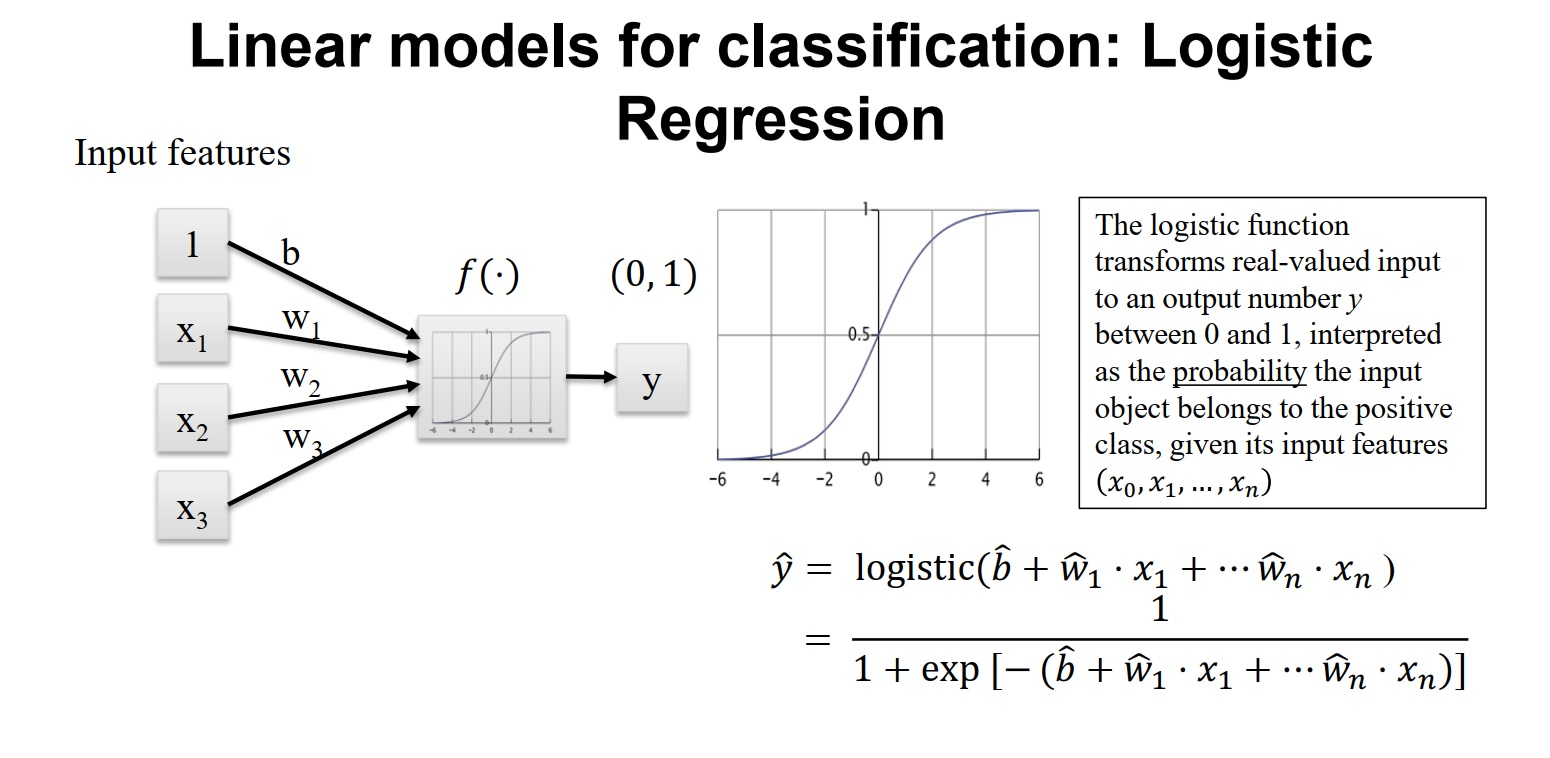

## Cross Entropy

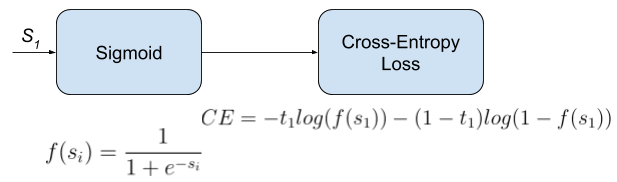

In [5]:
# Weight of shape [784, 10], the 28*28 image features, and total number of classes.
W = tf.Variable(tf.ones([num_features, num_classes]), name="weight")
# Bias of shape [10], the total number of classes.
b = tf.Variable(tf.zeros([num_classes]), name="bias")

# Logistic regression (Wx + b).
def logistic_regression(x):
    # Apply softmax to normalize the logits to a probability distribution.
    return tf.nn.softmax(tf.matmul(x, W) + b)

# Cross-Entropy loss function.
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)
    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    # Compute cross-entropy.
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred),1))

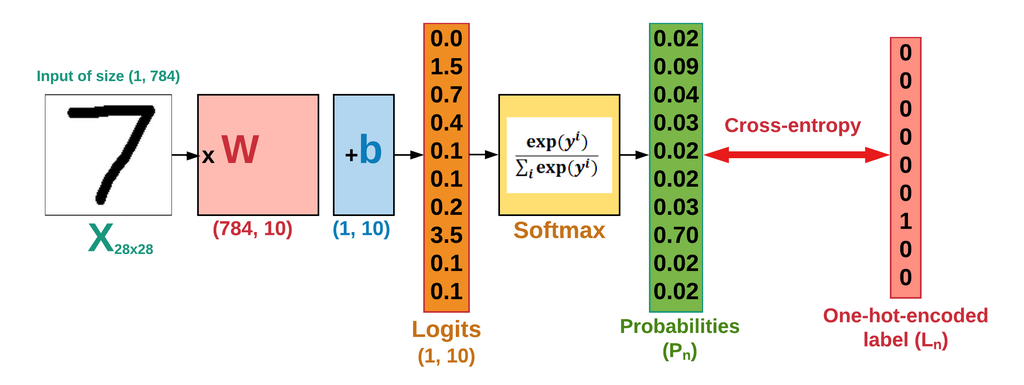

In [6]:
# Accuracy metric.
def accuracy(y_pred, y_true):
    # Predicted class is the index of highest score in prediction vector (i.e. argmax).
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

In [7]:

# Optimization process. 
def run_optimization(x, y):
    # Wrap computation inside a GradientTape for automatic differentiation.
    with tf.GradientTape() as g:
        pred = logistic_regression(x)
        loss = cross_entropy(pred, y)

    # Compute gradients.
    gradients = g.gradient(loss, [W, b])
    
    # Update W and b following gradients.
    optimizer.apply_gradients(zip(gradients, [W, b]))

In [8]:
# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Run the optimization to update W and b values.
    run_optimization(batch_x, batch_y)
    
    if step % display_step == 0:
        pred = logistic_regression(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        print("step: %i, loss: %f, accuracy: %f" % (step, loss, acc))

step: 50, loss: 1.828713, accuracy: 0.789062
step: 100, loss: 1.576345, accuracy: 0.742188
step: 150, loss: 1.377270, accuracy: 0.777344
step: 200, loss: 1.177680, accuracy: 0.839844
step: 250, loss: 1.104191, accuracy: 0.777344
step: 300, loss: 1.058983, accuracy: 0.769531
step: 350, loss: 0.953705, accuracy: 0.847656
step: 400, loss: 0.927974, accuracy: 0.804688
step: 450, loss: 0.846131, accuracy: 0.828125
step: 500, loss: 0.836926, accuracy: 0.812500
step: 550, loss: 0.765433, accuracy: 0.863281
step: 600, loss: 0.752745, accuracy: 0.863281
step: 650, loss: 0.738963, accuracy: 0.835938
step: 700, loss: 0.680254, accuracy: 0.851562
step: 750, loss: 0.754527, accuracy: 0.816406
step: 800, loss: 0.633672, accuracy: 0.859375
step: 850, loss: 0.640297, accuracy: 0.859375
step: 900, loss: 0.699990, accuracy: 0.835938
step: 950, loss: 0.704482, accuracy: 0.824219
step: 1000, loss: 0.598793, accuracy: 0.867188


In [9]:
# Test model on validation set.
pred = logistic_regression(x_test)
print("Test Accuracy: %f" % accuracy(pred, y_test))

Test Accuracy: 0.869400


In [10]:

# Visualize predictions.
import matplotlib.pyplot as plt

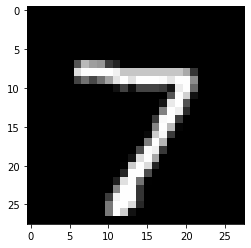

Model prediction: 7


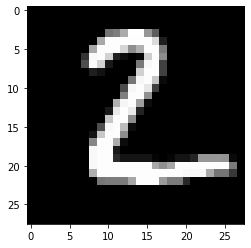

Model prediction: 2


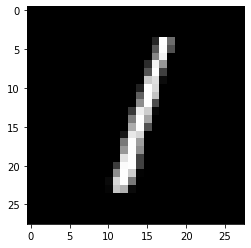

Model prediction: 1


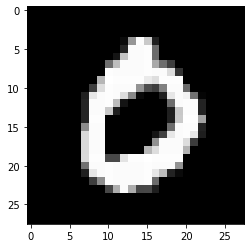

Model prediction: 0


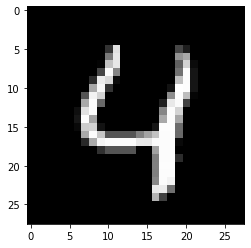

Model prediction: 4


In [11]:
# Predict 5 images from validation set.
n_images = 5
test_images = x_test[:n_images]
predictions = logistic_regression(test_images)

# Display image and model prediction.
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print("Model prediction: %i" % np.argmax(predictions.numpy()[i]))